## <center>Home assignment 1

made by Maxim Karpov

### Task 1

Load [wordcounts](http://www.leonidzhukov.net/hse/2015/networks/data/wordcounts.txt) dataset. 
1. Check that Zipf's Law holds
2. Assuming that the data is distributed according to the Power Law, find
 * $\alpha$ of the distribution
 * mean sample variance $\sigma^2$
3. Produce summary of the frequencies: min, max, mean, median

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.xkcd()
import networkx as nx
%matplotlib inline
from scipy.stats import kstest

#### Load dataset

In [2]:
wordcounts = np.loadtxt('datasets/wordcounts.txt', usecols=[0])

#### 1. Check that Zipf's Law holds

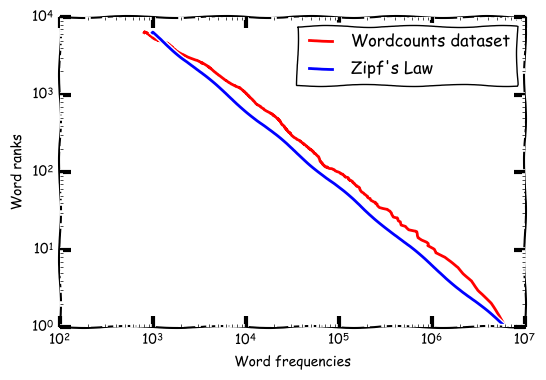

In [3]:
# make array of word ranks in ascending order
ranks = np.arange(1, len(wordcounts) + 1) 

# compute word frequencies according to Zipf's Law
zipf = []
k = 1
for i in range(len(wordcounts)):
    zipf.append(wordcounts[0] / k)
    k += 1
    
# plot 'Wordcounts dataset compared to Zipf's Law' in log-log scale
plt.loglog(wordcounts, ranks, c = 'r', label = 'Wordcounts dataset')
plt.loglog(zipf, ranks, c = 'b', label = "Zipf's Law")
plt.xlabel("Word frequencies")
plt.ylabel("Word ranks")
plt.legend()

From the plot above we see that Zipf's Law holds.

#### 2 Assuming that the data is distributed according to the Power Law, find 

i) $\alpha$ of the distribution

In [4]:
# Using MLE formula provided on lecture we'll find alpha

def mle(x, x_min):
    x = x[x >= x_min] # filtering out data below x_min
    return 1 + x.size / np.sum(np.log(x / x_min))

x_min1 = np.min(wordcounts)
Alpha = mle(wordcounts, x_min1)

print 'Alpha =', Alpha

Alpha = 1.71941763006


ii) mean sample $\sigma^2$

In [5]:
var = np.var(wordcounts)
print 'Sample variance =', var

Sample variance = 15360778764.5


As $\alpha$ < 3 the sample variance doesn't make any sense (the mean as well as $\alpha < 2$).

#### 3. Produce summary of the frequencies: min, max, mean, median

In [6]:
print("Min frequency: {}".format(int(wordcounts.min())))
print("Max frequency: {}".format(int(wordcounts.max())))
print("Mean: {}".format(wordcounts.mean()))
print("Median: {}".format(np.median(wordcounts)))

Min frequency: 800
Max frequency: 6187267
Mean: 13566.6707819
Median: 2335.0


### Task 2

Find and plot PDF and CDF for the following networks:
* [Routing network](http://www.leonidzhukov.net/hse/2015/networks/data/network.txt)
* [Web graph](http://www.leonidzhukov.net/hse/2015/networks/data/web_Stanford.txt)


* Are they correspondent to power law?
* Find max and mean values of incoming and outcoming node degrees
* Find $\alpha$ via Maximum Likelihood and calculate $\sigma^2$
* Determine $x_{min}$ via Kolmogorov-Smirnov test
* Try to fit Erdos model for the Web Graph and describe common and different points in their descriptive statistics

In [7]:
# loading datasets
file1 = "datasets/network.txt"
file2 = "datasets/web_Stanford.txt"

# pdf and ccdf
def empirical_pdf(x, num_bins=None):
    num_bins = num_bins if num_bins is not None else len(x)
    counts, bins = np.histogram(x, bins=num_bins, density=True)
    bins = bins[:-1] + (bins[1] - bins[0]) / 2
    probs = counts / counts.sum()
    return bins, probs

def empirical_ccdf(probs):
    return 1 - np.cumsum(probs)

## Routing network

In [8]:
edges = np.loadtxt(file1, skiprows=4, dtype="i8,i8")
G1 = nx.Graph()
G1.add_edges_from(edges)

In [9]:
# get node degrees and normalized nodes' degrees count
degrees = np.sort(np.array(list(G1.degree().values()), dtype=float))
e_pdf = empirical_pdf(degrees)
e_ccdf = empirical_ccdf(e_pdf[1])

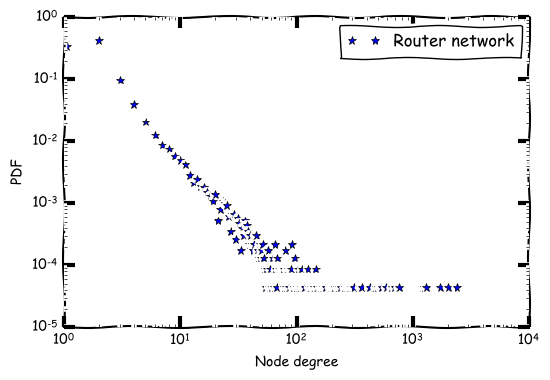

In [10]:
plt.loglog(e_pdf[0], e_pdf[1], '*', label='Router network')
plt.xlabel('Node degree')
plt.ylabel('PDF')
plt.legend()

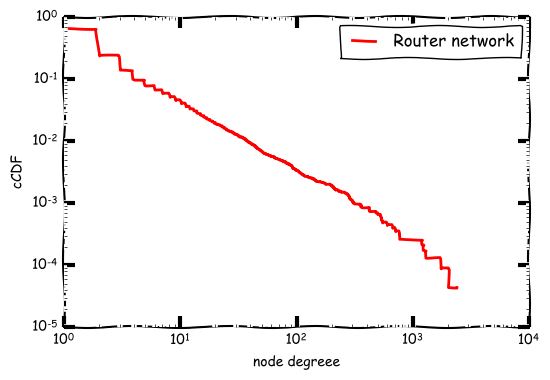

In [11]:
plt.loglog(e_pdf[0], e_ccdf, label='Router network', c = 'r')
plt.xlabel('node degreee')
plt.ylabel('cCDF')
plt.legend()

Power law _holds_ as most data from PDF and cCDF graphs are linear in log scale.

In [12]:
# mean and max values of node degrees (this graph is undirectional)

print("Mean node degree: {:.2f}".format(degrees.mean()))
print("Maximum node degree: {}".format(degrees.max()))

Mean node degree: 4.22
Maximum node degree: 2390.0


Finding $\alpha$ and $x_{min}$ via Kolmogorov-Smirnov test on whole data

In [13]:
# defining Kolmogorov-Smirnov test

def ks(x, x_min):
    alpha = mle(x, x_min)
    cdf = lambda x: 1 - ((x / x_min) ** (-(alpha-1)))
    ks, p_value = kstest(x[x >= x_min], cdf)
    return ks, alpha, x_min

def ks_arr(data):
    arr = np.ndarray(shape=(data.size, 3))
    
    for i, x_min in enumerate(data):
        arr[i] = ks(data, x_min)
    
    return arr # arr shaped ks, alpha, x_min

def ks_min(ks_arr):
    index = np.nanargmin(ks_arr, axis=0)[0]
    return ks_arr[index] # arr shaped ks, alpha, x_min

In [16]:
nodes = np.unique(np.asarray(list(G1.degree().values()), dtype=float), return_counts=True)
x = nodes[0] # node degrees

ks_data = ks_arr(x)
ks_data_min = ks_min(ks_data)

print("Best α via MLE {:.6f} | x_min={:.0f}, K-S={:.6f}".format(ks_data_min[1], ks_data_min[2], ks_data_min[0]))

Best α via MLE 2.344557 | x_min=194, K-S=0.084180


As $\alpha$ <3 then $\sigma^2$ does not make any sense.

## Web graph

In [17]:
# getting edge data and creating graph structure
edges = np.loadtxt(file2, skiprows=4, dtype="i8,i8")
G2 = nx.DiGraph()
G2.add_edges_from(edges)

In [18]:
# get node degrees and normalized nodes degrees count
degrees_in = np.sort(np.array(list(G2.in_degree().values()), dtype=float))
degrees_out = np.sort(np.array(list(G2.out_degree().values()), dtype=float))
e_pdf_in = empirical_pdf(degrees_in)
e_pdf_out = empirical_pdf(degrees_out)
e_ccdf_in = empirical_ccdf(e_pdf_in[1])
e_ccdf_out = empirical_ccdf(e_pdf_out[1])

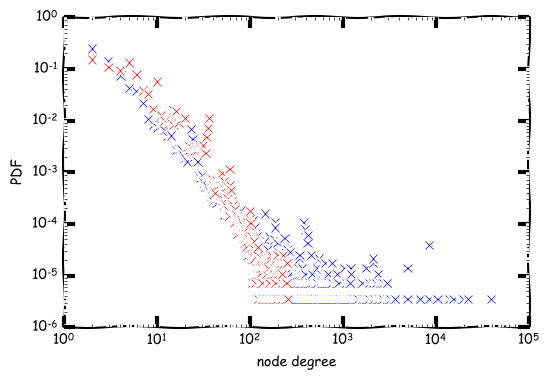

In [19]:
plt.loglog(e_pdf_in[0][10:], e_pdf_in[1][10:], 'x', label='Web graph (in)')
plt.loglog(e_pdf_out[0][1200:], e_pdf_out[1][1200:], 'xr', label='Web graph (out)')
plt.xlabel('node degree')
plt.ylabel('PDF')

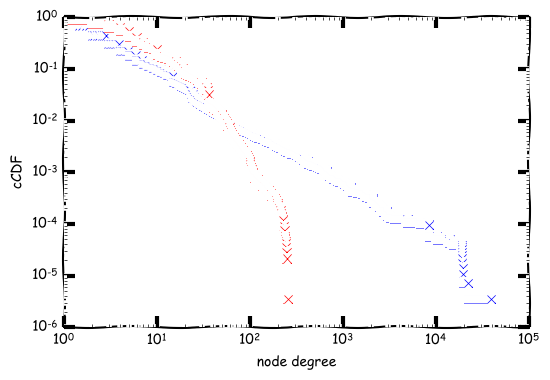

In [20]:
plt.loglog(e_pdf_in[0][10:-1], e_ccdf_in[10:-1], 'x', label='Web graph (in)')
plt.loglog(e_pdf_out[0][1200:-1], e_ccdf_out[1200:-1], 'x', label='Web graph (out)')
plt.xlabel('node degree')
plt.ylabel('cCDF')

Power law _holds_ as most data from PDF and cCDF graphs are linear in log scale.

In [21]:
# mean and max values of node degrees

print("Graph have {} nodes and {} edges".format(G2.order(), G2.size()))
print("In degree mean: {:.2f}, max: {}".format(degrees_in.mean(), degrees_in.max()))
print("Out degree mean: {:.2f}, max: {}".format(degrees_out.mean(), degrees_out.max()))

Graph have 281903 nodes and 2312497 edges
In degree mean: 8.20, max: 38606.0
Out degree mean: 8.20, max: 255.0


IN: Best α via MLE 2.108650 | x_min=549, K-S=0.056169
OUT: Best α via MLE 3.062887 | x_min=95, K-S=0.150825


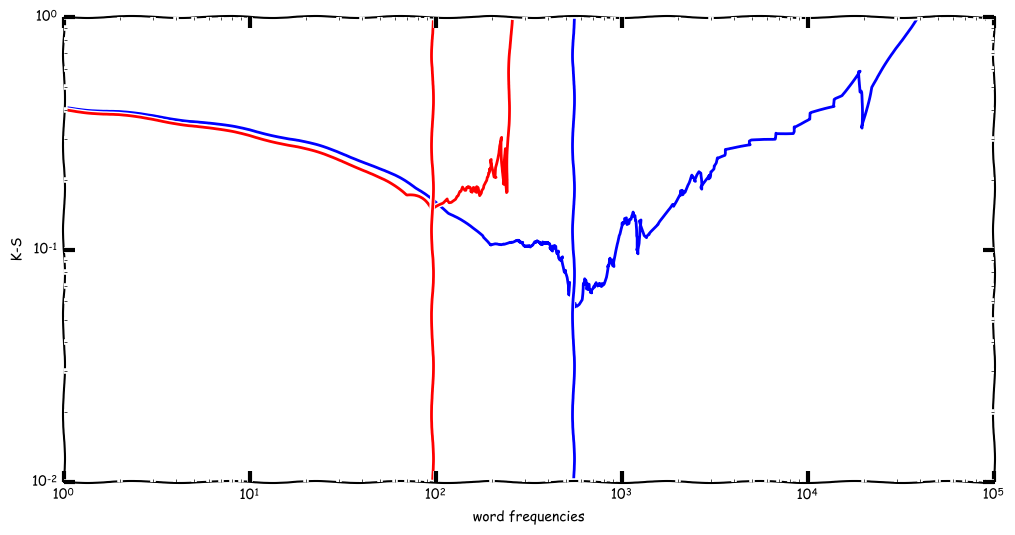

In [22]:
nodes_in = np.unique(np.asarray(list(G2.in_degree().values()), dtype=float), return_counts=True)
x_in = nodes_in[0][1:] # node in-degrees
nodes_out = np.unique(np.asarray(list(G2.out_degree().values()), dtype=float), return_counts=True)
x_out = nodes_out[0] # node out-degrees

ks_data_in = ks_arr(x_in)
ks_data_in_min = ks_min(ks_data_in)

ks_data_out = ks_arr(x_out)
ks_data_out_min = ks_min(ks_data_out)

plt.figure(figsize=(12, 6))
plt.loglog(x_in, ks_data_in[:,0], label='K-S in-degrees')
plt.loglog(x_out, ks_data_out[:,0], label='K-S out-degrees')
plt.axvline(x=ks_data_in_min[2])
plt.axvline(x=ks_data_out_min[2], color='red')
plt.xlabel('word frequencies')
plt.ylabel('K-S')

print("IN: Best α via MLE {:.6f} | x_min={:.0f}, K-S={:.6f}".format(ks_data_in_min[1], ks_data_in_min[2], ks_data_in_min[0]))
print("OUT: Best α via MLE {:.6f} | x_min={:.0f}, K-S={:.6f}".format(ks_data_out_min[1], ks_data_out_min[2], ks_data_out_min[0]))

As $\alpha < 3$, $\sigma^2$ for in-degrees does not exist.

As $\alpha > 3$, $\sigma^2$ for out-degrees exists, let's compute it.

In [23]:
def sigma(alpha, x_min):
    return ((alpha - 1.) / (alpha - 3)) * (x_min ** 2)

In [24]:
print("OUT: Estimated σ squared = {:.2f} | x_min={:.0f}".format(sigma(ks_data_out_min[1], ks_data_out_min[2]), ks_data_out_min[2]))

OUT: Estimated σ squared = 296047.72 | x_min=95
